# *Grid*, *Mesh*, *LocStream* and *Field* in detail

This example demonstrates how to use the basic classes in ESMPy:
- Grid
- Mesh
- LocStream
- Field

In [1]:
import esmpy
import numpy as np

In [2]:
# retrieve data files used in this notebook
import os
DD = os.path.join(os.getcwd(), "ESMPy-data")
if not os.path.isdir(DD):
    os.makedirs(DD)
from esmpy.util.cache_data import cache_data_file
cache_data_file(os.path.join(DD, "ll1deg_grid.nc"))
cache_data_file(os.path.join(DD, "ne30np4_esmf.nc"))
cache_data_file(os.path.join(DD, "so_Omon_GISS-E2.nc"))

True

The *Manager* is used to handle the calls to *ESMF_Initialize()* and *ESMF_Finalize()*. It also toggles the ESMF logging functionality with the *debug* flag and offers a basic interface to the ESMF *Virtual* *Machine*. In ESMF-speak a *pet* is a *persistent* *execution* *thread*, which in ESMPy is synonymous with a processing core. After initializing the *Manager* you can query the core count and rank of the current execution.

In [3]:
esmpy.Manager(debug=True)
print(esmpy.local_pet(), esmpy.pet_count())

0 1


In [4]:
import os
DD = os.path.join(os.getcwd(), "ESMPy-data")

A *Grid* can be created from file or explicitly (in-memory) with numpy arrays of coordinates. A *Grid* is used to represent a set of coordinates and data locations, but does not hold physical data itself. Creating a *Grid* from file is quick and easy.

In [5]:
gridfile = "ll1deg_grid.nc"
grid = esmpy.Grid(filename=os.path.join(DD, gridfile),
                 filetype=esmpy.FileFormat.SCRIP, add_corner_stagger=True)

In [6]:
# ESMPy follows ESMF/Fortran/Mathematics convention for indices in order lon, lat
lon = 0
lat = 1
print (grid.coords[esmpy.StaggerLoc.CENTER][lon].shape)

(360, 180)


In [7]:
# Coordinates are stored as numpy arrays, basic slicing capabilites are available
print (type(grid.coords[esmpy.StaggerLoc.CENTER][lon]))

print (grid.coords[esmpy.StaggerLoc.CENTER][lon][2:4])


<class 'numpy.ndarray'>
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
  3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
  3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
  3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
  3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
  3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.

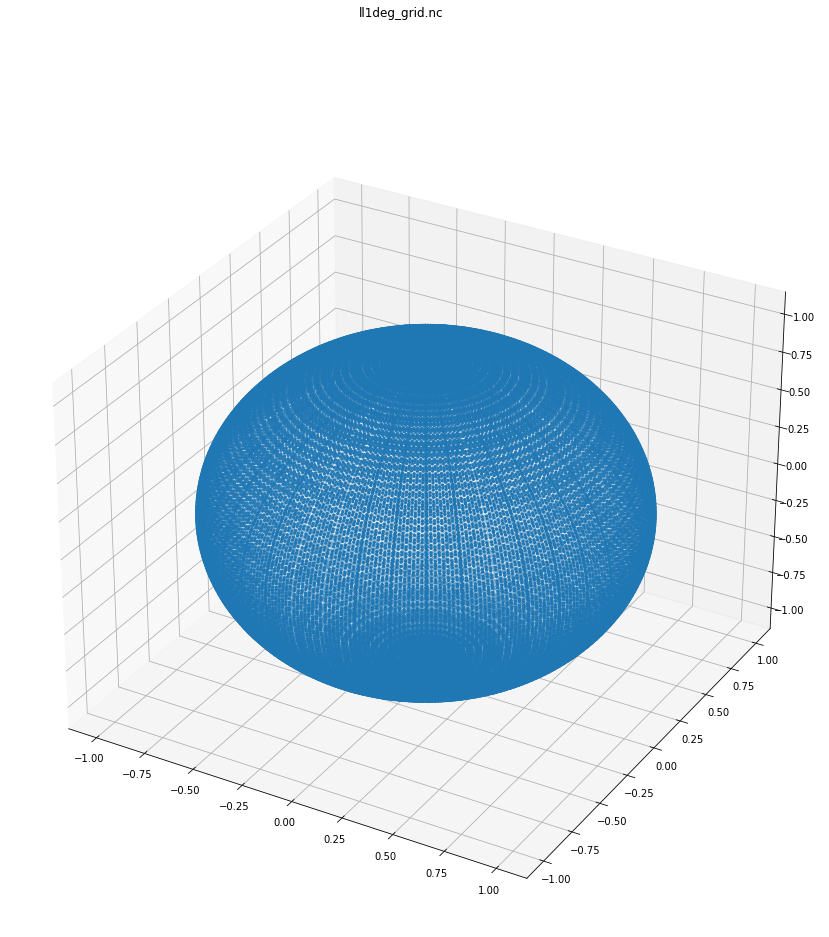

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(1, (15,15))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle(gridfile)

lons = grid.get_coords(0)
lats = grid.get_coords(1)

d2r = 180./np.pi

x = np.sin(d2r*lons)*np.cos(d2r*lats)
y = np.sin(d2r*lons)*np.sin(d2r*lats)
z = np.cos(d2r*lons)

im = ax.scatter(x,y,z, marker=".")

plt.show()

A *Grid* can also be created in-memory using numpy arrays of coordinates. This will create the same lat-lon 1 degree grid as above, with more data locations (*staggerloc*) and a different coordinate type (*coord_typekind*), but using the *pole_kind* to fill in the pole connections. *num_peri_dims* is required to specify a global grid.

In [9]:
max_index = np.array([360, 179])
grid = esmpy.Grid(max_index, staggerloc=[esmpy.StaggerLoc.CENTER, esmpy.StaggerLoc.EDGE1, esmpy.StaggerLoc.EDGE2, esmpy.StaggerLoc.CORNER], 
                 coord_sys=esmpy.CoordSys.SPH_DEG, 
                 coord_typekind=esmpy.TypeKind.R4, 
                 num_peri_dims = 1,
                 pole_kind=[esmpy.PoleKind.MONOPOLE, esmpy.PoleKind.BIPOLE])

gridLonCenter = grid.get_coords(0)
gridLatCenter = grid.get_coords(1)

lon = np.linspace(-180, 179, 360)
lat = np.linspace(-89, 89, 179)

gridLonCenter[...] = lon.reshape(lon.size, 1)
gridLatCenter[...] = lat.reshape(1, lat.size)

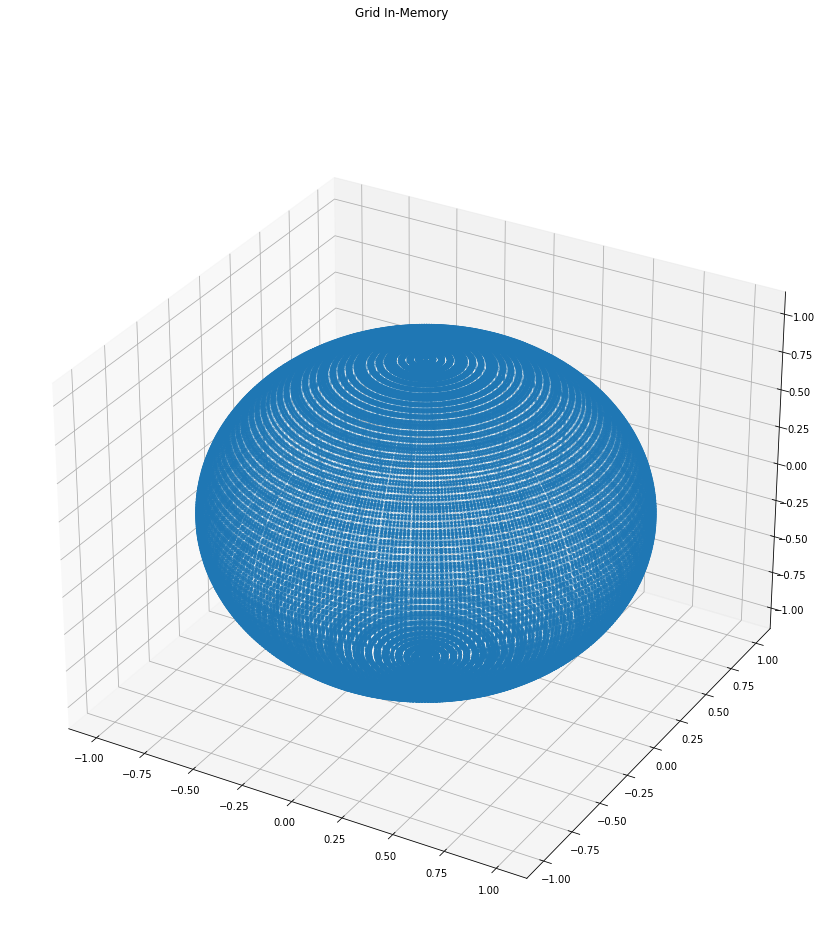

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(1, (15,15))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle("Grid In-Memory")

lons = grid.get_coords(0)
lats = grid.get_coords(1)

d2r = 180./np.pi

x = np.sin(d2r*lons)*np.cos(d2r*lats)
y = np.sin(d2r*lons)*np.sin(d2r*lats)
z = np.cos(d2r*lons)

im = ax.scatter(x,y,z, marker=".")

plt.show()

A *Mesh* is used to represent an unstructured grid. *Mesh* can also be used to represent structured grids, but stores more information than a *Grid* and uses more memory. A *Mesh* can be created from file, or in-memory with numpy arrays. The ESMF regridding back-end converts all *Grids* to *Mesh* objects
prior to calculating regridding weights, so if performance is a concern then it is best to start with *Mesh* objects to reduce weight generation times.

In [11]:
# cubed-sphere grid is represented as an unstructured Mesh
meshfile = "ne30np4_esmf.nc"
mesh = esmpy.Mesh(filename=os.path.join(DD, meshfile), filetype=esmpy.FileFormat.ESMFMESH)
# print(mesh)

In [12]:
# cmd = "ncdump -h ESMPy-data/ne30np4_esmf.nc"
# !{cmd}

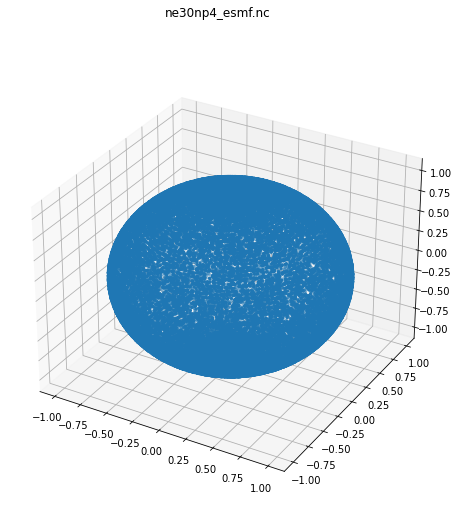

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(1, (8,8))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle(meshfile)

lons = mesh.get_coords(0)
lats = mesh.get_coords(1)

d2r = 180./np.pi

x = np.sin(d2r*lons)*np.cos(d2r*lats)
y = np.sin(d2r*lons)*np.sin(d2r*lats)
z = np.cos(d2r*lons)

im = ax.scatter(x,y,z, marker='.')

plt.show()

Creating a *Mesh* in-memory can get complicated very quickly. Care must be taken when defining coordinates and connectivity, as a single misplaced character can result in a malformed object. The connectivity array is defined using the index of the target id in the *nodeId* array. When creating a *Mesh* in parallel, this process can become significantly more complex. 

In [14]:
meshinmem = esmpy.Mesh(parametric_dim=2, spatial_dim=2)

num_node = 12
num_elem = 5
nodeId = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
nodeCoord = np.array([-0.1,-0.1,1.0,-0.1,2.1,-0.1,0.1,1.0,1.0,1.0,2.1,1.0,
                      0.1,2.1,0.5,2.5,1.0,2.1,1.5,2.5,2.5,2.5,2.5,2.1])
 
nodeOwner = np.zeros(num_node)

elemId = np.array([1,2,3,4,5])
elemType=np.array([esmpy.MeshElemType.QUAD,esmpy.MeshElemType.TRI,
                   esmpy.MeshElemType.TRI, 5, 6])
 
elemConn=np.array([0,1,4,3, 1,2,4, 2,5,4, 3,4,8,7,6, 4,5,11,10,9,8])

meshinmem.add_nodes(num_node,nodeId,nodeCoord,nodeOwner)

meshinmem.add_elements(num_elem,elemId,elemType,elemConn)


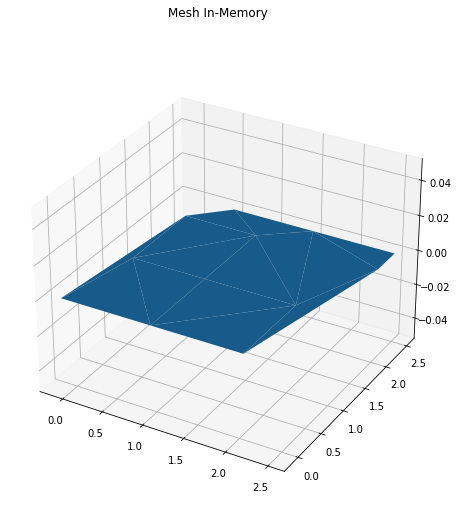

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(1, (8,8))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle("Mesh In-Memory")

x = meshinmem.get_coords(0)
y = meshinmem.get_coords(1)
z = np.zeros(len(x))

im = ax.plot_trisurf(x,y,z)

plt.show()

*LocStream* is used to represent a series of points with no connectivity, such as an observational data stream. A *LocStream* can not yet be created from file (this feature is available in ESMF but has not yet been ported to ESMPy). A *LocStream* can be created in memory using Python dictionaries.

In [16]:
# locstreams can currently only be created in memory
locstream = esmpy.LocStream(16)

locstream["ESMF:X"] = [0.0, 1.5, 2.5, 4.0, 0.0, 1.5, 2.5, 4.0, 0.0, 1.5, 2.5, 4.0, 0.0, 1.5, 2.5, 4.0]
locstream["ESMF:Y"] = [0.0, 0.0, 0.0, 0.0, 1.5, 1.5, 1.5, 1.5, 2.5, 2.5, 2.5, 2.5, 4.0, 4.0, 4.0, 4.0]
locstream["ESMF:Mask"] = [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

print(locstream)

LocStream:
    name = None 
    lower_bounds = array([0], dtype=int32) 
    upper_bounds = array([16], dtype=int32) 
    keys = dict_items([('ESMF:X', array([0. , 1.5, 2.5, 4. , 0. , 1.5, 2.5, 4. , 0. , 1.5, 2.5, 4. , 0. ,
       1.5, 2.5, 4. ])), ('ESMF:Y', array([0. , 0. , 0. , 0. , 1.5, 1.5, 1.5, 1.5, 2.5, 2.5, 2.5, 2.5, 4. ,
       4. , 4. , 4. ])), ('ESMF:Mask', array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))]) 



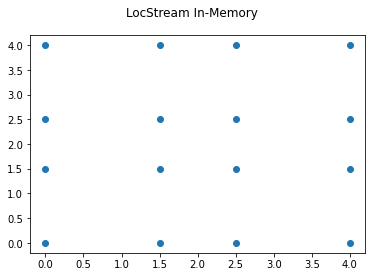

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
fig.suptitle("LocStream In-Memory")

im = ax.scatter(locstream["ESMF:X"],locstream["ESMF:Y"])

plt.show()

In [18]:
locstream = esmpy.LocStream(10, coord_sys=esmpy.CoordSys.SPH_RAD)

locstream["ESMF:Lon"] = np.linspace(0, 2*np.pi, 10).tolist()
locstream["ESMF:Lat"] = np.linspace(np.pi/-2.0, np.pi/2.0, 10).tolist()
locstream["ESMF:Mask"] = np.array([1,0,0,1,1,1,1,1,1,1], dtype=np.int32)

print(locstream)

LocStream:
    name = None 
    lower_bounds = array([0], dtype=int32) 
    upper_bounds = array([10], dtype=int32) 
    keys = dict_items([('ESMF:Lon', array([0.        , 0.6981317 , 1.3962634 , 2.0943951 , 2.7925268 ,
       3.4906585 , 4.1887902 , 4.88692191, 5.58505361, 6.28318531])), ('ESMF:Lat', array([-1.57079633, -1.22173048, -0.87266463, -0.52359878, -0.17453293,
        0.17453293,  0.52359878,  0.87266463,  1.22173048,  1.57079633])), ('ESMF:Mask', array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32))]) 



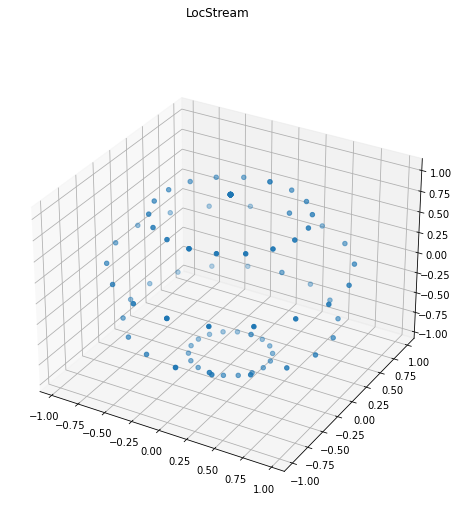

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(1, (8,8))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle('LocStream')

lons_1d = locstream["ESMF:Lon"]
lats_1d = locstream["ESMF:Lat"]

lons, lats = np.meshgrid(lons_1d, lats_1d)

x = np.sin(lons)*np.cos(lats)
y = np.sin(lons)*np.sin(lats)
z = np.cos(lons)

im = ax.scatter(x,y,z)

plt.show()

A *Field* can be created on any *Grid*, *Mesh* or *LocStream*. *Field*
data can be read from file, and there is limited support for extra (non-gridded and/or unlimited) dimensions. Note that the data location for a *Field* built on a *Grid* versus a *Mesh* uses a different keyword parameter (*staggerloc* or *meshloc*), and that there is no concept of data locations for a *LocStream* as it is merely a set of points without connectivity.

In [20]:
field_grid = esmpy.Field(grid, name="field_grid", typekind=esmpy.TypeKind.I8, staggerloc=esmpy.StaggerLoc.CORNER)
field_mesh = esmpy.Field(mesh, name="field_mesh", typekind=esmpy.TypeKind.R4, meshloc=esmpy.MeshLoc.ELEMENT)
field_locs = esmpy.Field(locstream, name="field_locs", typekind=esmpy.TypeKind.R4)
print(field_locs)

Field:
    name = 'field_locs'
    type = <TypeKind.R4: 5>
    rank = 1
    extra dimensions = 0
    staggerloc = <StaggerLoc.CENTER: 0>
    lower bounds = array([0], dtype=int32)
    upper bounds = array([10], dtype=int32)
    extra bounds = None
    data = array([1.2869256e-37, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       2.2420775e-44, 0.0000000e+00, 1.1210388e-44, 0.0000000e+00,
       6.7262326e-44, 0.0000000e+00], dtype=float32)
    grid = 
LocStream:
    name = None 
    lower_bounds = array([0], dtype=int32) 
    upper_bounds = array([10], dtype=int32) 
    keys = dict_items([('ESMF:Lon', array([0.        , 0.6981317 , 1.3962634 , 2.0943951 , 2.7925268 ,
       3.4906585 , 4.1887902 , 4.88692191, 5.58505361, 6.28318531])), ('ESMF:Lat', array([-1.57079633, -1.22173048, -0.87266463, -0.52359878, -0.17453293,
        0.17453293,  0.52359878,  0.87266463,  1.22173048,  1.57079633])), ('ESMF:Mask', array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32))]) 

)


Extra (i.e. ungridded and unlimited) dimensions can be added to a *Field* to represent concepts like vertical layers and time. Recall that ESMPy uses ESMF/Fortran/Mathematics index ordering for coordinates [longitude, latitude], the extra dimensions follow, with the unlimited dimension last. In the following example we will read in a *Grid* from file and create a *Field* with one extra ungridded but limited dimension (vertical layers) and one extra ungridded unlimited dimension (time). In this case the index order is: [longitude, latitude, levels, time]

In [21]:
# NASA-GISS sea water salinity data with 33 vertical layers and 2 timesteps
grid_so = esmpy.Grid(filename=os.path.join(DD, "so_Omon_GISS-E2.nc"),
                 filetype=esmpy.FileFormat.GRIDSPEC, add_corner_stagger=True, add_mask=True, varname="so")

timeslice = 12
field_so = esmpy.Field(grid_so, ndbounds=[33, 2])

field_so.read(filename=os.path.join(DD, "so_Omon_GISS-E2.nc"), 
           variable="so", timeslice=2)

In [22]:
field_so.data.shape

(360, 180, 33, 2)

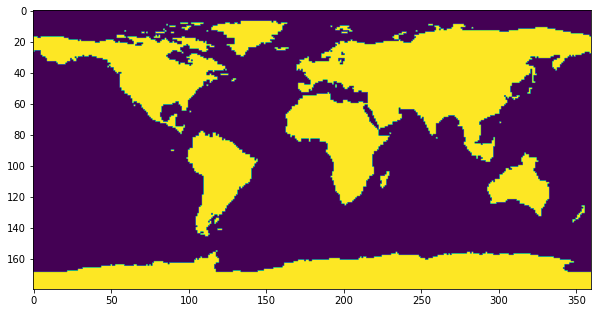

In [23]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

fig = plt.figure(1, (10,10))
ax = fig.add_subplot(111)
# fig.suptitle('Evolution of sea water salinity in vertical layers')

lons = grid_so.get_coords(0)
lats = grid_so.get_coords(1)

x = np.sin(lons)*np.cos(lats)
y = np.sin(lons)*np.sin(lats)
z = np.cos(lons)

im = ax.imshow(np.flipud(field_so.data[:,:,5,1].T))

In [24]:
# cmd = "ncdump -h ESMPy-data/so_Omon_GISS-E2.nc"
# !{cmd}